# Dataset : Statlog German Credit Risk
####  The dataset classifies people described by a set of attributes as good or bad credit risks, the aim is to apply autoencoders to customer's seeking loans and flag any abnormal behavior

#### 1. Load Libraries

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve,accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score
from pandas.api.types import is_numeric_dtype
import urllib

#### 2. Read Dataset

In [45]:
# Read dataset from url:
url="http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
raw_data = urllib.request.urlopen(url)
credit=pd.DataFrame(raw_data)
data = pd.read_csv(url, delimiter=' ', header=None)

# Labeling the columns of the dataset:
data.columns = ['HasChecking', 'DurationInMonths', 'CreditHistory', 'CreditPurpose', 'CreditAmount', 'SavingsAccount', 
                'EmployedSince', 'InstallmentRatePercentIncome', 'StatusGender','OtherDebtorsGuarantors', 'ResidenceSince', 
                'Property', 'Age', 'OtherInstallmentPlans', 'Housing','NumberExistingCredits', 'Job', 'FamilyLiablities', 
                'HasPhone', 'ForeignWorker', 'CreditRisk']
data.head()

,HasChecking,DurationInMonths,CreditHistory,CreditPurpose,CreditAmount,SavingsAccount,EmployedSince,InstallmentRatePercentIncome,StatusGender,OtherDebtorsGuarantors,...,Property,Age,OtherInstallmentPlans,Housing,NumberExistingCredits,Job,FamilyLiablities,HasPhone,ForeignWorker,CreditRisk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


#### 3. Understanding Dataset

In [48]:
## Numerical columns
numerical_features = [f for f in list(data) if is_numeric_dtype(data[f])]
print("List of numerical columns:\n",numerical_features)

List of numerical columns:
 ['DurationInMonths', 'CreditAmount', 'InstallmentRatePercentIncome', 'ResidenceSince', 'Age', 'NumberExistingCredits', 'FamilyLiablities', 'CreditRisk']


In [49]:
## Categorical columns
non_numerical_features = [f for f in list(data) if f not in numerical_features]
print("List of categorical columns:\n",non_numerical_features)

List of categorical columns:
 ['HasChecking', 'CreditHistory', 'CreditPurpose', 'SavingsAccount', 'EmployedSince', 'StatusGender', 'OtherDebtorsGuarantors', 'Property', 'OtherInstallmentPlans', 'Housing', 'Job', 'HasPhone', 'ForeignWorker']


In [52]:
## Creating dummy vars out of non_numerical_features
data_ready = pd.get_dummies(data,
                            columns=non_numerical_features,
                            drop_first=False,
                            dummy_na=False)
print("Data Shape: ",data_ready.shape)
data_ready.head()

Data Shape:  (1000, 62)


,DurationInMonths,CreditAmount,InstallmentRatePercentIncome,ResidenceSince,Age,NumberExistingCredits,FamilyLiablities,CreditRisk,HasChecking_A11,HasChecking_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,HasPhone_A191,HasPhone_A192,ForeignWorker_A201,ForeignWorker_A202
0,6,1169,4,4,67,2,1,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,2,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,2,1,0,...,0,1,0,0,1,0,1,0,1,0


In [53]:
## from data notes we know that: (1 = Good, 2 = Bad)
data_ready[['CreditRisk',
            'HasChecking_A11',
            'HasChecking_A12',
            'HasChecking_A13',
            'HasChecking_A14']].groupby('CreditRisk').sum()

,HasChecking_A11,HasChecking_A12,HasChecking_A13,HasChecking_A14
CreditRisk,,,,
1,139.0,164.0,49.0,348.0
2,135.0,105.0,14.0,46.0


In [54]:
# fixing binary outcome - 0 will be good credit and 1 will be bad credit
data_ready['CreditRisk'].replace([1,2], [0,1], inplace=True)
data_ready['CreditRisk'].value_counts()

0    700
1    300
Name: CreditRisk, dtype: int64

In [55]:
# save data set to file to run it into FastML.io
data_ready.to_csv("german-credit-scores-ready.csv", index=None)

#### 4. Prepare train/test split for autoencoder

In [56]:
## Details :
print("Data Shape: ",data_ready.shape)
features = [f for f in list(data_ready) if f not in ['CreditRisk']]
print("Length of feature: ",len(features))
X_train, X_test, Y_train, Y_test = train_test_split(data_ready[features],
                                                    data_ready['CreditRisk'],
                                                    test_size=0.3,
                                                    random_state=1)
print('Data split - Train:', len(X_train), 'Test:', len(X_test))

# Also, check for nulls
print("Null values, if any: ", X_train.isnull().values.sum())

Data Shape:  (1000, 62)
Length of feature:  61
Data split - Train: 700 Test: 300
Null values, if any:  0


#### 5. Create set of negative outcomes only

In [57]:
X_train_0 = X_train.copy()
X_train_0['CreditRisk'] = Y_train
X_train_0 = X_train_0[X_train_0['CreditRisk']==0]
X_train_0 = X_train_0.drop('CreditRisk', axis=1)
X_test_0 = X_test.copy()
X_test_0['CreditRisk'] = Y_test
X_test_0 = X_test_0[X_test_0['CreditRisk']==0]
X_test_0 = X_test_0.drop('CreditRisk', axis=1)

#### 6. Modeling

In [59]:
# Defining Autoencoder parameters:
nb_epoch = 500
batch_size = 128
input_dim = X_train_0.shape[1]
encoding_dim = 24
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3


# Setting up autoencoder layers:
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 61)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                1488      
_________________________________________________________________
dense_11 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_12 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_13 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_14 (Dense)             (None, 61)                1525      
Total params: 3,781
Trainable params: 3,781
Non-trainable params: 0
_________________________________________________________

In [60]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                     save_best_only=True,
                     verbose=0)

tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True, 
                 write_images=True)

## Fitting Autoencoder :
history = autoencoder.fit(X_train_0, X_train_0,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test_0, X_test_0),
                          verbose=1,
                          callbacks=[cp, tb]).history

Epoch 1/500
4/4 [==============================] - 0s 107ms/step - loss: 239962.8438 - accuracy: 0.0000e+00 - val_loss: 249773.3906 - val_accuracy: 0.0000e+00
Epoch 2/500
4/4 [==============================] - 0s 32ms/step - loss: 235411.8281 - accuracy: 0.0000e+00 - val_loss: 245485.2969 - val_accuracy: 0.0000e+00
Epoch 3/500
4/4 [==============================] - 0s 33ms/step - loss: 231426.8594 - accuracy: 0.0000e+00 - val_loss: 240905.7812 - val_accuracy: 0.0000e+00
Epoch 4/500
4/4 [==============================] - 0s 33ms/step - loss: 226765.0000 - accuracy: 0.0000e+00 - val_loss: 235793.9688 - val_accuracy: 0.0000e+00
Epoch 5/500
4/4 [==============================] - 0s 30ms/step - loss: 221450.8438 - accuracy: 0.0000e+00 - val_loss: 229768.2031 - val_accuracy: 0.0000e+00
Epoch 6/500
4/4 [==============================] - 0s 36ms/step - loss: 215670.1094 - accuracy: 0.0000e+00 - val_loss: 222585.7969 - val_accuracy: 0.0000e+00
Epoch 7/500
4/4 [==============================] - 

Epoch 57/500
4/4 [==============================] - 0s 17ms/step - loss: 28.0059 - accuracy: 1.0000 - val_loss: 26.6528 - val_accuracy: 1.0000
Epoch 58/500
4/4 [==============================] - 0s 47ms/step - loss: 28.0584 - accuracy: 1.0000 - val_loss: 26.4228 - val_accuracy: 1.0000
Epoch 59/500
4/4 [==============================] - 0s 64ms/step - loss: 28.1102 - accuracy: 1.0000 - val_loss: 26.3908 - val_accuracy: 1.0000
Epoch 60/500
4/4 [==============================] - 0s 23ms/step - loss: 28.2308 - accuracy: 1.0000 - val_loss: 26.5512 - val_accuracy: 1.0000
Epoch 61/500
4/4 [==============================] - 0s 42ms/step - loss: 28.5154 - accuracy: 1.0000 - val_loss: 26.3638 - val_accuracy: 1.0000
Epoch 62/500
4/4 [==============================] - 0s 21ms/step - loss: 28.6595 - accuracy: 1.0000 - val_loss: 26.6568 - val_accuracy: 1.0000
Epoch 63/500
4/4 [==============================] - 0s 21ms/step - loss: 28.3456 - accuracy: 1.0000 - val_loss: 26.3984 - val_accuracy: 1.0000

Epoch 171/500
4/4 [==============================] - 0s 36ms/step - loss: 24.0478 - accuracy: 1.0000 - val_loss: 22.6868 - val_accuracy: 1.0000
Epoch 172/500
4/4 [==============================] - 0s 19ms/step - loss: 23.7668 - accuracy: 1.0000 - val_loss: 23.2062 - val_accuracy: 1.0000
Epoch 173/500
4/4 [==============================] - ETA: 0s - loss: 27.7340 - accuracy: 1.000 - 0s 24ms/step - loss: 24.0529 - accuracy: 1.0000 - val_loss: 22.6283 - val_accuracy: 1.0000
Epoch 174/500
4/4 [==============================] - 0s 26ms/step - loss: 24.0059 - accuracy: 1.0000 - val_loss: 22.5281 - val_accuracy: 1.0000
Epoch 175/500
4/4 [==============================] - 0s 16ms/step - loss: 23.8458 - accuracy: 1.0000 - val_loss: 22.6120 - val_accuracy: 1.0000
Epoch 176/500
4/4 [==============================] - 0s 32ms/step - loss: 23.9426 - accuracy: 1.0000 - val_loss: 22.5059 - val_accuracy: 1.0000
Epoch 177/500
4/4 [==============================] - 0s 22ms/step - loss: 23.7355 - accuracy

Epoch 284/500
4/4 [==============================] - 0s 19ms/step - loss: 21.2210 - accuracy: 1.0000 - val_loss: 20.3288 - val_accuracy: 1.0000
Epoch 285/500
4/4 [==============================] - 0s 18ms/step - loss: 20.8576 - accuracy: 1.0000 - val_loss: 20.1073 - val_accuracy: 1.0000
Epoch 286/500
4/4 [==============================] - 0s 27ms/step - loss: 20.9537 - accuracy: 1.0000 - val_loss: 19.8406 - val_accuracy: 1.0000
Epoch 287/500
4/4 [==============================] - 0s 30ms/step - loss: 20.7185 - accuracy: 1.0000 - val_loss: 19.6816 - val_accuracy: 1.0000
Epoch 288/500
4/4 [==============================] - 0s 25ms/step - loss: 20.9444 - accuracy: 1.0000 - val_loss: 19.8658 - val_accuracy: 1.0000
Epoch 289/500
4/4 [==============================] - 0s 17ms/step - loss: 20.9500 - accuracy: 1.0000 - val_loss: 19.7935 - val_accuracy: 1.0000
Epoch 290/500
4/4 [==============================] - 0s 21ms/step - loss: 20.6558 - accuracy: 1.0000 - val_loss: 19.8409 - val_accuracy:

Epoch 341/500
4/4 [==============================] - 0s 20ms/step - loss: 20.0351 - accuracy: 1.0000 - val_loss: 18.9105 - val_accuracy: 1.0000
Epoch 342/500
4/4 [==============================] - 0s 34ms/step - loss: 20.0891 - accuracy: 1.0000 - val_loss: 18.7850 - val_accuracy: 1.0000
Epoch 343/500
4/4 [==============================] - 0s 22ms/step - loss: 20.0170 - accuracy: 1.0000 - val_loss: 18.8702 - val_accuracy: 1.0000
Epoch 344/500
4/4 [==============================] - 0s 21ms/step - loss: 19.7327 - accuracy: 1.0000 - val_loss: 18.7992 - val_accuracy: 1.0000
Epoch 345/500
4/4 [==============================] - 0s 18ms/step - loss: 19.7687 - accuracy: 1.0000 - val_loss: 19.1234 - val_accuracy: 1.0000
Epoch 346/500
4/4 [==============================] - 0s 21ms/step - loss: 19.5310 - accuracy: 1.0000 - val_loss: 18.8737 - val_accuracy: 1.0000
Epoch 347/500
4/4 [==============================] - 0s 34ms/step - loss: 19.8874 - accuracy: 1.0000 - val_loss: 18.7614 - val_accuracy:

Epoch 398/500
4/4 [==============================] - 0s 20ms/step - loss: 19.7139 - accuracy: 1.0000 - val_loss: 18.2368 - val_accuracy: 1.0000
Epoch 399/500
4/4 [==============================] - 0s 20ms/step - loss: 20.5478 - accuracy: 1.0000 - val_loss: 19.2956 - val_accuracy: 1.0000
Epoch 400/500
4/4 [==============================] - 0s 19ms/step - loss: 21.4773 - accuracy: 1.0000 - val_loss: 18.8117 - val_accuracy: 1.0000
Epoch 401/500
4/4 [==============================] - 0s 17ms/step - loss: 20.1027 - accuracy: 1.0000 - val_loss: 19.4421 - val_accuracy: 1.0000
Epoch 402/500
4/4 [==============================] - 0s 17ms/step - loss: 19.8848 - accuracy: 1.0000 - val_loss: 18.5154 - val_accuracy: 1.0000
Epoch 403/500
4/4 [==============================] - 0s 19ms/step - loss: 19.2340 - accuracy: 1.0000 - val_loss: 19.1141 - val_accuracy: 1.0000
Epoch 404/500
4/4 [==============================] - 0s 19ms/step - loss: 19.4501 - accuracy: 1.0000 - val_loss: 18.2799 - val_accuracy:

Epoch 455/500
4/4 [==============================] - 0s 32ms/step - loss: 18.6433 - accuracy: 1.0000 - val_loss: 17.5849 - val_accuracy: 1.0000
Epoch 456/500
4/4 [==============================] - 0s 20ms/step - loss: 18.4958 - accuracy: 1.0000 - val_loss: 17.6139 - val_accuracy: 1.0000
Epoch 457/500
4/4 [==============================] - 0s 20ms/step - loss: 18.5232 - accuracy: 1.0000 - val_loss: 17.7824 - val_accuracy: 1.0000
Epoch 458/500
4/4 [==============================] - 0s 20ms/step - loss: 18.6208 - accuracy: 1.0000 - val_loss: 17.7153 - val_accuracy: 1.0000
Epoch 459/500
4/4 [==============================] - 0s 23ms/step - loss: 18.6468 - accuracy: 1.0000 - val_loss: 17.9450 - val_accuracy: 1.0000
Epoch 460/500
4/4 [==============================] - 0s 29ms/step - loss: 18.6912 - accuracy: 1.0000 - val_loss: 17.5458 - val_accuracy: 1.0000
Epoch 461/500
4/4 [==============================] - 0s 19ms/step - loss: 19.1456 - accuracy: 1.0000 - val_loss: 17.8927 - val_accuracy:

In [63]:
## Prediction and MSE Scoring:
test_x_predictions = autoencoder.predict(X_test)
print("Test prediction shape: ",test_x_predictions.shape)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
print("\nmse: \n",mse)

Test prediction shape:  (300, 61)

mse: 
 507     6.691530
818    68.889960
452     4.349541
368    11.943677
242    11.740905
         ...    
459     0.830947
415     1.567533
61     24.796114
347     0.899494
349     9.026473
Length: 300, dtype: float64


In [64]:
Y_test.value_counts()

0    214
1     86
Name: CreditRisk, dtype: int64

In [65]:
fpr, tpr, thresholds = roc_curve(Y_test, mse)
print('thresholds: ', np.mean(thresholds))
auc(fpr, tpr)

thresholds:  12.862488946793743


0.572049554444686

In [66]:
# fixing threshold:
threshold_fixed = 21.05
accuracy_score(Y_test, [1 if s > threshold_fixed else 0 for s in mse])

0.66

#### 7. Plotting Reconstruction Error for Different Classes

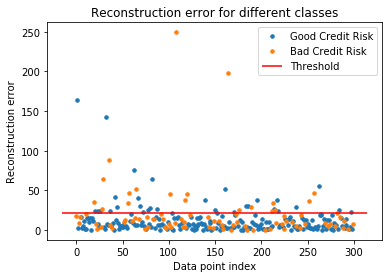

In [33]:
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                              'True_class': Y_test})
error_df_test = error_df_test.reset_index()
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
 ax.plot(group.index,
         group.Reconstruction_error,
         marker='o',
         ms=3.5,
         linestyle='',
         label= "Bad Credit Risk" if name == 1 else "Good Credit Risk")
ax.hlines(threshold_fixed, ax.get_xlim()[0], 
          ax.get_xlim()[1], 
          colors="r",
          zorder=100, 
          label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

#### 8. Confusion Matrix

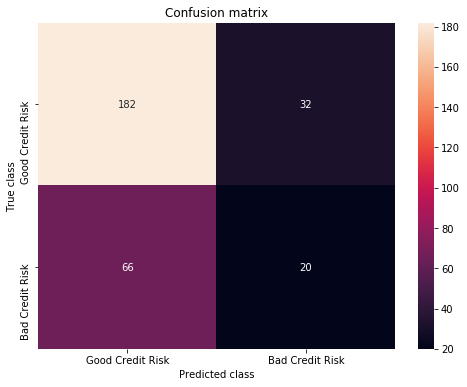

In [67]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test['Reconstruction_error'].values]
conf_matrix = confusion_matrix(error_df_test['True_class'], pred_y)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            xticklabels=["Good Credit Risk","Bad Credit Risk"],
            yticklabels=["Good Credit Risk","Bad Credit Risk"],
            annot=True, 
            fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

#### 9. ROC Curve

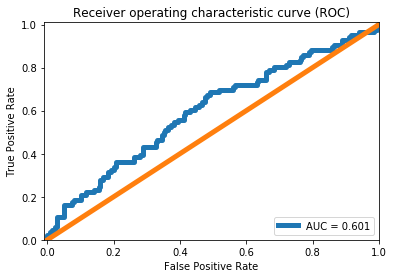

In [68]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df_test['True_class'],
                                                      error_df_test['Reconstruction_error'])
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 10. Analyzing the Results

In [69]:
# some of those features that we see via poor reconstruction error:
X_test['Error'] = mse
X_test['CreditRisk'] = Y_test
X_test = X_test.sort_values('Error', ascending=False)
X_test.head()

,DurationInMonths,CreditAmount,InstallmentRatePercentIncome,ResidenceSince,Age,NumberExistingCredits,FamilyLiablities,HasChecking_A11,HasChecking_A12,HasChecking_A13,...,Job_A171,Job_A172,Job_A173,Job_A174,HasPhone_A191,HasPhone_A192,ForeignWorker_A201,ForeignWorker_A202,Error,CreditRisk
236,6,14555,1,2,23,1,1,0,1,0,...,1,0,0,0,0,1,1,0,131.944490,1
887,48,15672,2,2,23,1,1,0,1,0,...,0,0,1,0,0,1,1,0,92.204025,1
818,36,15857,2,3,43,1,1,1,0,0,...,0,0,0,1,1,0,1,0,68.889960,0
756,6,1299,1,1,74,3,2,0,0,1,...,1,0,0,0,1,0,0,1,65.799908,0
744,39,14179,4,4,30,2,1,1,0,0,...,0,0,0,1,0,1,1,0,61.578057,0


In [76]:
normal_values = X_test[X_test['CreditRisk']==0].mean()
normal_values

DurationInMonths                  19.191589
CreditAmount                    3053.785047
InstallmentRatePercentIncome       3.018692
ResidenceSince                     2.808411
Age                               35.542056
                                   ...     
HasPhone_A192                      0.425234
ForeignWorker_A201                 0.943925
ForeignWorker_A202                 0.056075
Error                             10.742280
CreditRisk                         0.000000
Length: 63, dtype: float64

In [77]:
diff_values = normal_values - X_test.head(10)
diff_values = diff_values.T
diff_values

,236,887,818,756,744,187,430,13,816,769
DurationInMonths,13.191589,-28.808411,-16.808411,13.191589,-19.808411,3.191589,14.191589,-4.808411,13.191589,7.191589
CreditAmount,-11501.214953,-12618.214953,-12803.214953,1754.785047,-11125.214953,1878.785047,-394.214953,1854.785047,1715.785047,1398.785047
InstallmentRatePercentIncome,2.018692,1.018692,1.018692,2.018692,-0.981308,1.018692,2.018692,-0.981308,2.018692,1.018692
ResidenceSince,0.808411,0.808411,-0.191589,1.808411,-1.191589,-0.191589,-1.191589,-1.191589,-1.191589,-1.191589
Age,12.542056,12.542056,-7.457944,-38.457944,5.542056,-32.457944,-38.457944,-24.457944,-26.457944,-27.457944
...,...,...,...,...,...,...,...,...,...,...
HasPhone_A192,-0.574766,-0.574766,0.425234,0.425234,-0.574766,-0.574766,0.425234,0.425234,0.425234,-0.574766
ForeignWorker_A201,-0.056075,-0.056075,-0.056075,0.943925,-0.056075,-0.056075,-0.056075,-0.056075,-0.056075,-0.056075
ForeignWorker_A202,0.056075,0.056075,0.056075,-0.943925,0.056075,0.056075,0.056075,0.056075,0.056075,0.056075
Error,-121.202211,-81.461745,-58.147680,-55.057628,-50.835777,-45.949580,-34.795630,-34.673999,-32.403497,-30.943422


In [40]:
# pick an index header and analyze, at random:
customer = 236
to_analyze = pd.DataFrame(diff_values[customer])
to_analyze = to_analyze.sort_values(customer, ascending=True)
print(to_analyze.head(1))
print(to_analyze.tail(1))

                       236
CreditAmount -11501.214953
                        236
DurationInMonths  13.191589


In [78]:
X_test[['CreditAmount','CreditRisk']].groupby('CreditRisk').mean()

,CreditAmount
CreditRisk,
0,3053.785047
1,4035.046512


In [79]:
X_test[['DurationInMonths','CreditRisk']].groupby('CreditRisk').mean()

,DurationInMonths
CreditRisk,
0,19.191589
1,25.116279


In [80]:
# pick an index header and analyze, at ranodm:
customer = 887
to_analyze = pd.DataFrame(diff_values[customer])
to_analyze = to_analyze.sort_values(customer, ascending=True)
print(to_analyze.head(1))
print(to_analyze.tail(1))

                       887
CreditAmount -12618.214953
           887
Age  12.542056
